### np-bragg-laue
The goal here is to extend the simple numpy version of nanobragg to multiple wavelengths. 
The inputs required will be structure factors, an A matrix, and a reciprocal lattice point size. 
The user will also supply the $S_1$ vectors for every pixel.

The way it will work, is that we calculate the location in reciprocal space where each S1 vector crosses the ewald sphere. 
Then we will approximate the scattering cross section of that pixel by summing the contributions from every reflection. 
$r_h  = hA^{-1}$

$$I_p = \sum_h F_h e^{\big(\frac {S1_p - r_h}{r_s}\big)^2}  $$

Populating the interactive namespace from numpy and matplotlib


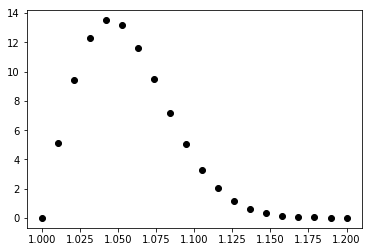

In [1]:
%pylab inline
import tensorflow as tf
from multiprocessing import Pool
from tqdm import tqdm

#Spectral properties of the beam
wavelengths = np.linspace(1, 1.2, 20)
x = wavelengths - wavelengths.min()
sigma = 0.01*(x.max() - x.min())
#This is the PDF of a rayleigh distribution
weights = np.exp(-np.square(x)/2/sigma)*x/sigma
plt.plot(wavelengths, weights, 'ko')

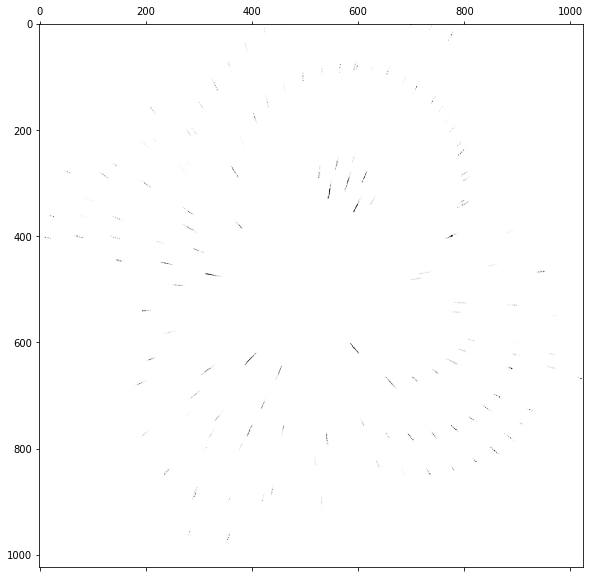

In [25]:
floattype=np.float16
chunks = 50
pixels = 1024 #number of pixels on each axis
pixelsize = .1 #mm
hmax = 10
detector_distance = 100
Rs = 0.001
ewald_offset_tol = 0.01

detector_ori = np.array([
    -pixels*pixelsize/2,
    -pixels*pixelsize/2,
    detector_distance,
], dtype=floattype)

fast_axis = np.array([1, 0, 0], dtype=floattype)
slow_axis = np.array([0, 1, 0], dtype=floattype)

A = np.array([
    [30., 0., 0.],
    [ 0.,40., 0.],
    [ 0., 0.,30.],
], dtype=floattype)

from scipy.stats import special_ortho_group
A = np.matmul(special_ortho_group.rvs(3), A)

H = np.array(np.meshgrid(np.arange(-hmax, hmax, dtype=np.int8), np.arange(-hmax, hmax, dtype=np.int8), np.arange(-hmax, hmax, dtype=np.int8))).reshape((3, 8*hmax**3))
H[:,H.sum(0) != 0] #No 0,0,0 reflection
I = np.sqrt(-np.log(np.random.random(len(H.T))))

P = np.array(np.meshgrid(
    np.arange(pixels, dtype=floattype),
    np.arange(pixels, dtype=floattype)
)).reshape((2, pixels**2))

P.shape

detector_basis = np.vstack((fast_axis, slow_axis))

Rp = np.matmul(P.T, pixelsize*detector_basis) + detector_ori

image = np.zeros((pixels, pixels),dtype=floattype)
from tqdm.autonotebook import tqdm

Rh = np.matmul(H.T, np.linalg.inv(A)) + [0 , 0, 1/wavelengths.max()]
Dh = np.linalg.norm(Rh, 2, 1)
indices = (Dh > 1/wavelengths.max()) 

Rh = np.matmul(H.T, np.linalg.inv(A)) + [0 , 0, 1/wavelengths.min()]
Dh = np.linalg.norm(Rh, 2, 1)
indices = indices & (Dh < 1/wavelengths.min())
indices = np.where(indices)[0]


def helperfun(idx):
    Rh_sel = Rh[idx]
    I_sel = I[idx]
    S1 = Rp/np.linalg.norm(Rp, 2, 1)[:,None]/wavelength
    return np.matmul(I_sel, np.exp(-np.square(np.linalg.norm(S1 - Rh_sel[:,None,:], 2, -1)/Rs))).reshape((pixels, pixels))

for i in tqdm(range(len(wavelengths))):
    wavelength,weight = wavelengths[i], weights[i]
    Rh = np.matmul(H.T, np.linalg.inv(A)) + [0 , 0, 1/wavelength]
    for idx in np.array_split(indices, chunks):
        Rh_sel = Rh[idx]
        I_sel = I[idx]
        S1 = Rp/np.linalg.norm(Rp, 2, 1)[:,None]/wavelength
        image += np.matmul(I_sel, np.exp(-np.square(np.linalg.norm(S1 - Rh_sel[:,None,:], 2, -1)/Rs))).reshape((pixels, pixels))
    #with Pool(6) as p:
        #images = p.map(helperfun, np.array_split(indices, chunks))
    #image += weight*np.sum(images)

f = plt.figure(figsize=(10,10))
ax = plt.gca()
ax.matshow(np.log(1+np.array(image.astype(np.float64))), cmap='Greys')